## The purpose of this notebook is to detect issue and check the maps

### Study square

Import packages 

In [2]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.ops import nearest_points, split
from rasterio.mask import mask
from rasterio.features import rasterize
from rasterio.plot import show
from rasterio.transform import from_origin
from scipy.ndimage import distance_transform_edt
from shapely.geometry import box
from matplotlib.patches import Rectangle
from collections import deque
from pathlib import Path

#from ..source.map_utils import *

In [3]:
# Reading layers
trails = gpd.read_file("../data/SENTIERI.shp")
roads = gpd.read_file("../data/Viabilita_Pubblica.shp")


# Setting CRS, assuming they are in EPSG:3004, so that you can then reproject it
trails = trails.set_crs('EPSG:3004', allow_override=True)
roads = roads.set_crs('EPSG:3004', allow_override=True)

# Reprojection to EPSG:32632 (same as raster and park)
trails = trails.to_crs('EPSG:32632')
roads = roads.to_crs('EPSG:32632')


DataSourceError: ../data/SENTIERI.shp: No such file or directory

Definition of the square

In [ ]:
side = 3000

# Define the size of the square in metres (if projected in metres; otherwise in degrees)
x_start = 819500
y_start = 5137500

bbox = box(x_start, y_start, x_start + side, y_start + side)

Display

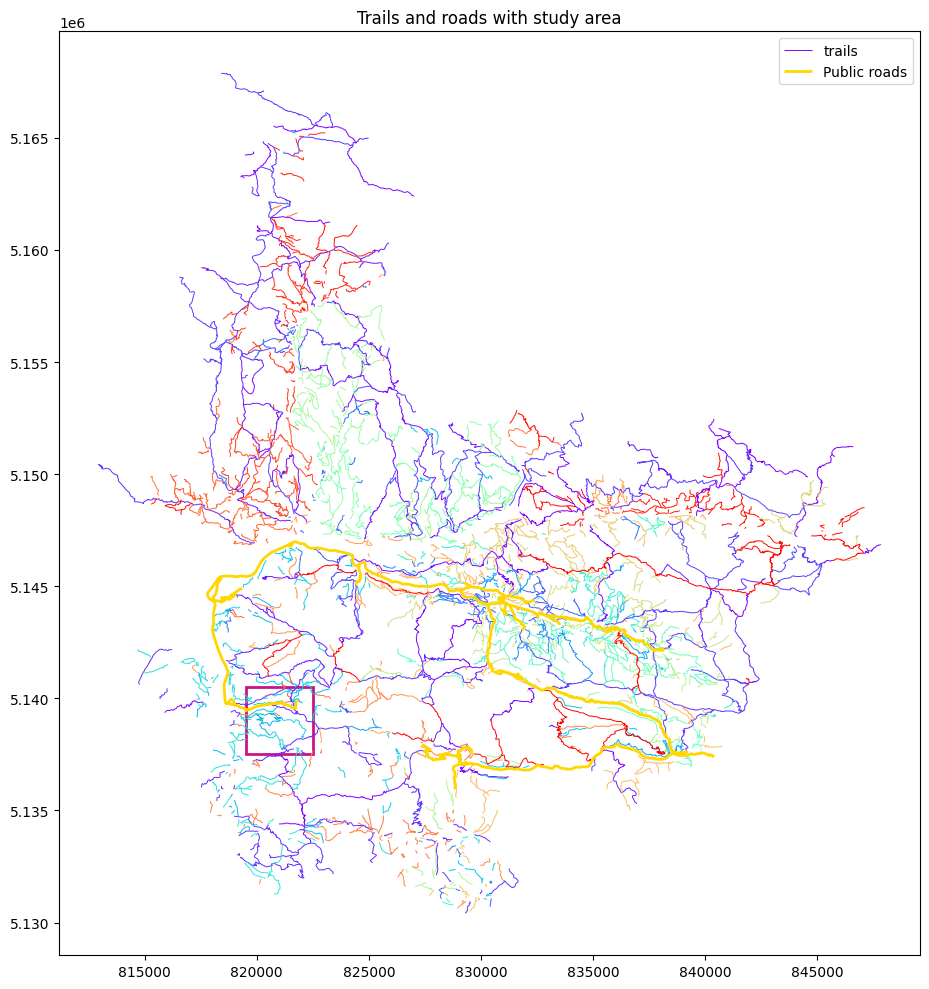

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

trails.plot(ax=ax, cmap="rainbow", linewidth=0.7, label="trails")
roads.plot(ax=ax, color="gold", linewidth=2, label="Public roads")

rect = Rectangle(
    (x_start, y_start),
    side, side,
    linewidth=2,
    edgecolor='mediumvioletred',
    facecolor='none'
)
ax.add_patch(rect)
ax.legend()
ax.set_title("Trails and roads with study area")
plt.tight_layout()
plt.show()


In [ ]:
# import the library
import folium

# Make an empty map
m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)

# Show the map
m

In [ ]:
from shapely.geometry import Point
from shapely.ops import nearest_points
from collections import defaultdict, deque
import geopandas as gpd
import heapq

class CuttingPoint:
    def __init__(self, geom):
        self.geom = geom
        self.neighbors = []  # list of (CuttingPoint, weight)
        self.dist = float('inf')

    def __hash__(self):
        return hash((round(self.geom.x, 3), round(self.geom.y, 3)))  # Tolerance
    def __eq__(self, other):
        return self.geom.equals_exact(other.geom, tolerance=1e-3)

def build_graph_from_roads(roads_gdf):
    """
    Build a graph of CuttingPoints from the roads GeoDataFrame.
    """
    point_to_cp = dict()
    graph = defaultdict(list)

    for idx, row in roads_gdf.iterrows():
        geom = row.geometry
        if geom.geom_type != "LineString":
            continue  # skip non-line geometries

        start_pt = Point(geom.coords[0])
        end_pt = Point(geom.coords[-1])
        length = geom.length

        for pt in [start_pt, end_pt]:
            if pt not in point_to_cp:
                point_to_cp[pt] = CuttingPoint(pt)

        cp1 = point_to_cp[start_pt]
        cp2 = point_to_cp[end_pt]

        cp1.neighbors.append((cp2, length))
        cp2.neighbors.append((cp1, length))  # bidirectional

    return list(point_to_cp.values()), point_to_cp

def compute_dijkstra_from_point(cutting_points, point_source):
    """
    Run Dijkstra from a given Point and return all distances.
    """
    # Find closest CuttingPoint to the point_source
    source_cp = min(cutting_points, key=lambda cp: cp.geom.distance(point_source))
    source_cp.dist = 0
    queue = [(0, source_cp)]

    visited = set()

    while queue:
        current_dist, current_cp = heapq.heappop(queue)
        if current_cp in visited:
            continue
        visited.add(current_cp)

        for neighbor, weight in current_cp.neighbors:
            alt = current_dist + weight
            if alt < neighbor.dist:
                neighbor.dist = alt
                heapq.heappush(queue, (alt, neighbor))

    return cutting_points  # each .dist field now has shortest distance from source


In [ ]:

cutting_points, _ = build_graph_from_roads(roads)

# Point de départ pour le parcours (par exemple une coordonnée centrale)
start_point = Point(830500, 5140500)

cutting_points = compute_dijkstra_from_point(cutting_points, start_point)

# Afficher les distances
for cp in cutting_points:
    print(f"CuttingPoint at {cp.geom} -> distance = {cp.dist:.2f}")


CuttingPoint at POINT (818712.0473567732 5139759.643398291) -> distance = 27330.66
CuttingPoint at POINT (818996.5065918395 5139735.574591021) -> distance = 27655.80
CuttingPoint at POINT (821829.9328200049 5139821.138621922) -> distance = 31350.76
CuttingPoint at POINT (818086.8690174208 5144311.744895208) -> distance = 22506.69
CuttingPoint at POINT (818041.8841161157 5144500.948256654) -> distance = inf
CuttingPoint at POINT (819357.5613434946 5144902.744804178) -> distance = inf
CuttingPoint at POINT (823176.3345808967 5146615.526469534) -> distance = 15564.35
CuttingPoint at POINT (829088.2219966776 5144802.971851804) -> distance = 8608.16
CuttingPoint at POINT (830312.4671960722 5144140.810700855) -> distance = 7103.53
CuttingPoint at POINT (832795.7786548777 5140352.346276628) -> distance = 0.00
CuttingPoint at POINT (838150.1911554085 5138444.113348937) -> distance = 6845.64
CuttingPoint at POINT (838350.9678777773 5138211.3298180625) -> distance = 7255.13
CuttingPoint at POINT

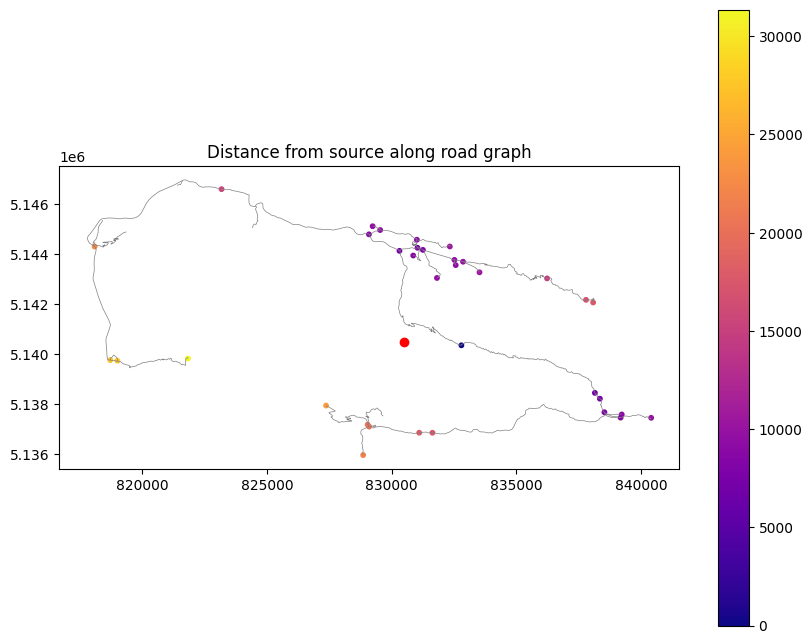

In [ ]:
import math
import geopandas as gpd

# Construction GeoDataFrame uniquement avec les CuttingPoints accessibles
gdf = gpd.GeoDataFrame(
    [{"geometry": cp.geom, "distance": cp.dist} for cp in cutting_points if not math.isinf(cp.dist)],
    crs=roads.crs
)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
roads.plot(ax=ax, color='gray', linewidth=0.5)
gdf.plot(ax=ax, column="distance", legend=True, cmap="plasma", markersize=10)
plt.plot(830500, 5140500, 'ro')
plt.title("Distance from source along road graph")
plt.show()



In [ ]:
import sys
print(sys.executable)


/Users/emmad/Documents/DifficultyMapv2.4.1.f/.venv/bin/python


EPSG:2154
EPSG:2154
[ 986490.12471958 6765772.09222945 1019792.89039477 6790805.76226379]
[ 987490. 6767772. 1018792. 6788805.]


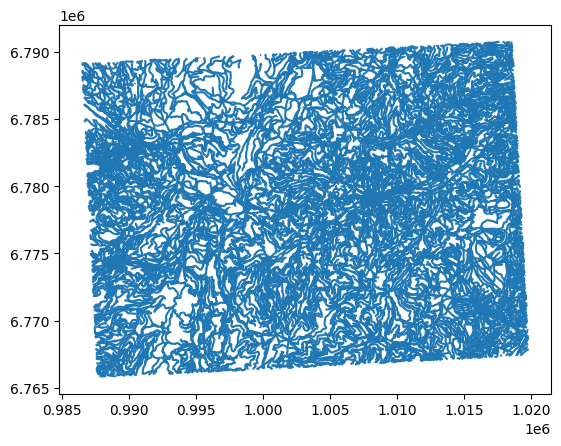

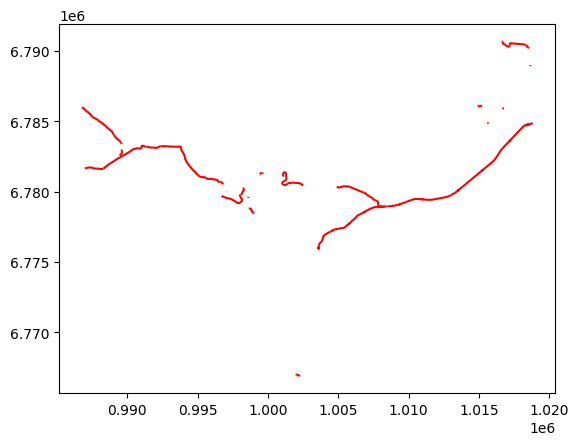

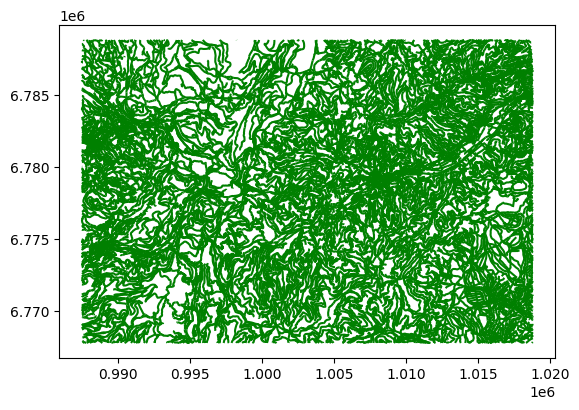

In [26]:


TRAILS_PATH = "../data/france_test/roads_src_2154.shp"
ROADS_PATH = "../data/france_test/railways_src_2154.shp"
RASTER_PATH = "../data/france_test/raster_fr.tif"
ORIGINAL_CRS = "EPSG:2154"
TARGET_CRS   = "EPSG:2154"

# ----------------------------- #
# DATA LOADING AND PREPARATION
# ----------------------------- #

def read_and_prepare_layers(original_crs=ORIGINAL_CRS, target_crs=TARGET_CRS):
    """
    Load trails and roads shapefiles, assign and reproject CRS.
    """
    trails = gpd.read_file(TRAILS_PATH)
    print(trails.crs)
    roads = gpd.read_file(ROADS_PATH)
    print(roads.crs)
    return trails, roads

trails, roads = read_and_prepare_layers()

trails.plot()
roads.plot(color='red')
print(trails.total_bounds)

xmin, ymin, xmax, ymax = 987490, 6767772, 1018792, 6788805
roi = box(xmin, ymin, xmax, ymax)

# Mettre la boîte dans un GeoDataFrame pour bien gérer le CRS
roi_gdf = gpd.GeoDataFrame(geometry=[roi], crs=trails.crs)

# Rogner les sentiers avec la bbox
gdf_clip = gpd.overlay(trails, roi_gdf, how="intersection")

# Sauvegarder le résultat
gdf_clip.to_file("../data/france_test/roads_src_adjusted.shp")
gdf_clip.plot(color="green")
print(gdf_clip.total_bounds)

EPSG:2154
EPSG:2154


<Axes: >

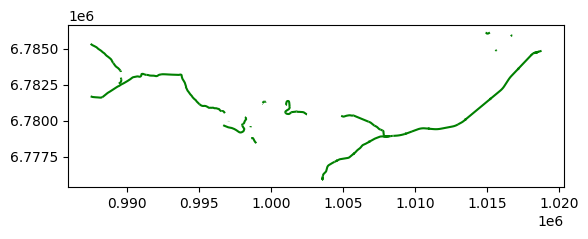

In [27]:
trails, roads = read_and_prepare_layers()

xmin, ymin, xmax, ymax = 987490, 6767772, 1018792, 6788805
roi = box(xmin, ymin, xmax, ymax)

# Mettre la boîte dans un GeoDataFrame pour bien gérer le CRS
roi_gdf = gpd.GeoDataFrame(geometry=[roi], crs=roads.crs)

# Rogner les sentiers avec la bbox
gdf_clip = gpd.overlay(roads, roi_gdf, how="intersection")

# Sauvegarder le résultat
gdf_clip.to_file("../data/france_test/railways_src_adjusted.shp")
gdf_clip.plot(color="green")

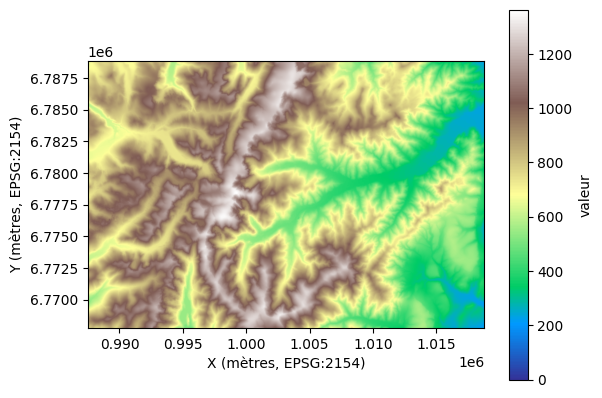

In [28]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import matplotlib.pyplot as plt


# Les bounds que tu veux garder (dans ton CRS EPSG:2154)
xmin, ymin, xmax, ymax = 987490, 6767772, 1018792, 6788805
bbox = box(xmin, ymin, xmax, ymax)

with rasterio.open(RASTER_PATH) as src:
    out_image, out_transform = mask(src, [bbox], crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Sauvegarde
with rasterio.open("../data/france_test/raster_fr_adjusted.tif", "w", **out_meta) as dest:
    dest.write(out_image)

# Affichage avec coordonnées réelles
with rasterio.open("raster_rogné.tif") as clipped:
    data = clipped.read(1)

    # Calcul de l'extent : (xmin, xmax, ymin, ymax)
    extent = [xmin, xmax, ymin, ymax]

    plt.imshow(data, cmap="terrain", extent=extent)
    plt.colorbar(label="valeur")
    plt.xlabel("X (mètres, EPSG:2154)")
    plt.ylabel("Y (mètres, EPSG:2154)")
    plt.show()


In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_raster(input_path, output_path, dst_crs=TARGET_CRS):
    with rasterio.open(input_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height
        })

        with rasterio.open(output_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.bilinear,
                )

# Exemple d’utilisation
reproject_raster(RASTER_PATH, "france_slope_new_crs.tif")


In [ ]:
def mask_raster(bbox):
    """
    Apply a bounding box mask to a raster and return the masked array and updated metadata.
    """
    with rasterio.open("france_slope_new_crs.tif") as src:
        out_image, out_transform = mask(src, [bbox.__geo_interface__], crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        data = out_image[0]
        data = np.where(data == -9999.0, np.nan, data)
    return data, out_meta


x_box = 1003141
y_box = 6779388
half_side = 3000
study_area_box = box(x_box - half_side, y_box - half_side, x_box + half_side, y_box + half_side)

data, out_meta=mask_raster(study_area_box )


AttributeError: 'DatasetReader' object has no attribute 'plot'